# Expanded nested cross validation

In [1]:
#Importing key modules

import numpy as np # for mathematical computation
import pandas as pd # for mathematical computation

from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV
import joblib


from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.svm import SVC

from sklearn.metrics import(
    accuracy_score, 

    classification_report, 
    confusion_matrix, 
    precision_recall_fscore_support
)


from time import time


%matplotlib inline
import matplotlib.pyplot as plt # for plotting

import seaborn as sns # for plotting


sns.set(
    context = "paper",
    style = "white",
    palette = "deep",
    font_scale = 2.0,
    color_codes = True,
    rc = ({"font.family": "Dejavu Sans"})
    )

%matplotlib inline
plt.rcParams["figure.figsize"] = [6,4]

In [16]:
#| label: functions
# define functions

def ml_loop(
    X_train,
    y_train_species,
    kf,
    num_rounds: int,
    random_grid: dict,
    scoring: str,
    species_model,
    name 
):
    """
    Perform a machine learning loop with cross-validation and randomized grid search.

    This function performs a machine learning loop that includes cross-validation,
    randomized grid search for hyperparameter tuning, and model evaluation. It
    trains and evaluates the model multiple times (specified by num_rounds) and
    collects the results.

    Parameters
    ----------
    X_train : array-like of shape (n_samples, n_features)
        The training input samples.
    y_train_species : array-like of shape (n_samples,)
        The true labels for the training samples.
    kf : cross-validation generator
        A cross-validation generator, such as KFold or StratifiedKFold.
    num_rounds : int
        The number of rounds to run the loop.
    random_grid : dict
        The hyperparameter grid for randomized search.
    scoring : str
        The scoring metric to evaluate the model, e.g., 'accuracy'.
    species_model : estimator object
        The machine learning model to be used, e.g., an instance of SVC.

    Returns
    -------
    species_predicted : list
        A list of predicted labels for the test samples across all rounds.
    species_true : list
        A list of true labels for the test samples across all rounds.
    kf_results : pd.DataFrame
        A DataFrame containing the model parameters and global accuracy scores.
    kf_per_class_results : list
        A list of per-class accuracy scores for
    

    """
    start = time()
    kf_results = pd.DataFrame() # model parameters and global accuracy score
    kf_per_class_results = []
    species_predicted, species_true = [], []
    
    for vuelta in range(num_rounds):
        print(f"\nThis is round {vuelta+1}...\n")
        SEED = np.random.randint(0, 81478)

        # Before your cross-validation loop
        # y_species_train = np.where(y_species_train == 'AA', 0, 1)

        # Inside your cross-validation loop, this step is not needed as the data is already encoded

        # cross validation and splitting of the validation set
        for train_index, test_index in kf.split(X_train, y_train_species):
            X_train_set, X_test_set = X_train[train_index], X_train[test_index]
            y_train_species_set, y_val_species_set = (
                y_train_species[train_index],
                y_train_species[test_index],
            )

            # print('The shape of X train set : {}'.format(X_train_set.shape))
            # print('The shape of y train species : {}'.format(y_train_species_set.shape))
            # print('The shape of X test set : {}'.format(X_test_set.shape))
            # print('The shape of y test species : {}\n'.format(y_val_species_set.shape))

            # generate models using all combinations of settings

            # RANDOMSED GRID SEARCH
            # Random search of parameters, using 5 fold cross validation,
            # search across 100 different combinations, and use all available cores

            n_iter_search = 10
            rsCV = RandomizedSearchCV(
                verbose=1,
                estimator=species_model,
                param_distributions=random_grid,
                n_iter=n_iter_search,
                scoring=scoring,
                cv=kf,
                refit=True,
                n_jobs=-1,
            )

            rsCV_result = rsCV.fit(X_train_set, y_train_species_set)

            # print out results and give hyperparameter settings for best one
            means = rsCV_result.cv_results_["mean_test_score"]
            stds = rsCV_result.cv_results_["std_test_score"]
            params = rsCV_result.cv_results_["params"]
            # for mean, stdev, param in zip(means, stds, params):
            # print("Accuracy of %.2f $\pm$(%.2f) with: %r" % (mean, stdev, param))

            # print best parameter settings
            print(
                "Best accuracy: %.2f using %s"
                % (rsCV_result.best_score_, rsCV_result.best_params_)
            )

            # Insert the best parameters identified by randomized grid search into the base classifier
            species_classifier = species_model.set_params(**rsCV_result.best_params_)

            # Fit your models
            species_classifier.fit(X_train_set, y_train_species_set)

            # predict test instances
            sp_predictions = species_classifier.predict(X_test_set)

            # zip all predictions for plotting averaged confusion matrix
            # species
            for predicted_sp, true_sp in zip(sp_predictions, y_val_species_set):
                species_predicted.append(predicted_sp)
                species_true.append(true_sp)

            # species local confusion matrix & classification report
            local_cm_species = confusion_matrix(y_val_species_set, sp_predictions)
            local_report_species = classification_report(
                y_val_species_set, sp_predictions
            )

            # append feauture importances
            # local_feat_impces_species = pd.DataFrame(species_classifier.feature_importances_,
            #                                    index = features.columns).sort_values(by = 0, ascending = False)

            # summarizing results
            local_kf_results = pd.DataFrame(
                [
                    (
                        "Accuracy_species",
                        accuracy_score(y_val_species_set, sp_predictions),
                    ),
                    ("TRAIN", str(train_index)),
                    ("TEST", str(test_index)),
                    ("CM", local_cm_species),
                    ("Classification report", local_report_species),
                    ("y_test", y_val_species_set),
                    # ("Feature importances", #local_feat_impces_species.to_dict())
                ]
            ).T

            local_kf_results.columns = local_kf_results.iloc[0]
            local_kf_results = local_kf_results[1:]
            kf_results = pd.concat(
                [kf_results, local_kf_results], axis=0, join="outer"
            ).reset_index(drop=True)

            # per class accuracy
            local_support = precision_recall_fscore_support(
                y_val_species_set, sp_predictions
            )[3]
            local_acc = np.diag(local_cm_species) / local_support
            kf_per_class_results.append(local_acc)
    elapsed = time() - start
    print(f"\nTime elapsed: {elapsed:.2f} seconds")

    filename = "./results/models/trained_model_" + name + ".sav"
    joblib.dump(species_classifier, filename)

    return species_true, species_predicted, kf_results

def confusion_matrix_mau(y_pred, y_true, xticks_rotation=None, ax=None):
    """
    Displays a normalized confusion matrix using the true and predicted labels.

    This function generates and displays a normalized confusion matrix using the
    true labels (`y_true`) and the predicted labels (`y_pred`). The confusion
    matrix is displayed using a grayscale colormap and is normalized to show
    proportions instead of raw counts.

    Args:
        y_pred (array-like of shape (n_samples,)): The predicted labels.
        y_true (array-like of shape (n_samples,)): The true labels.
        ax (matplotlib.axes.Axes, optional): The axes on which to plot the confusion matrix.
            If None, the current axes will be used.

    Returns:
        None
    """
    ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=y_true,normalize='true', values_format='.2f', cmap=plt.cm.Greys, ax=ax, im_kw={'vmin':0, 'vmax':1}, xticks_rotation=xticks_rotation)

In [6]:
#| label: loaddata
# Loading data
df=pd.read_csv("./data/UV_pilot.csv")

train_set, test_set = train_test_split(
                            df, 
                            stratify = df["Exposed"], 
                            test_size = 0.2, 
                            shuffle = True, 
                            random_state = 42
                            )

In [9]:
#| label: trainset 
train_set

,Specie,Sex,Exposed,Reeplicate,ID,4006,4004,4002,4000,3998,...,415,413,411,409,407,405,403,401,399,397
38,AG,F,NOU,R1,0,0.00606,0.00633,0.00645,0.00641,0.00630,...,0.27204,0.27022,0.27061,0.27248,0.27390,0.27571,0.27762,0.27621,0.27455,0
93,AG,F,YES,R1,4,0.00721,0.00707,0.00694,0.00675,0.00670,...,0.32102,0.32095,0.31825,0.31510,0.31353,0.31366,0.31579,0.32116,0.32686,0
0,AG,F,YES,R1,2,0.00477,0.00462,0.00448,0.00434,0.00439,...,0.33421,0.33535,0.33473,0.33308,0.33221,0.33094,0.33106,0.33498,0.34019,0
25,AG,F,YES,R1,2,0.00385,0.00373,0.00366,0.00357,0.00377,...,0.31823,0.31901,0.31912,0.31971,0.32106,0.31962,0.31680,0.31756,0.32199,0
64,AG,F,YES,R1,1,0.00494,0.00477,0.00468,0.00460,0.00468,...,0.30981,0.31129,0.31186,0.31023,0.30699,0.30595,0.30871,0.31130,0.31167,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,AG,F,NOU,R1,4,0.00679,0.00693,0.00694,0.00687,0.00679,...,0.25786,0.25613,0.25454,0.25483,0.25630,0.25775,0.25947,0.26051,0.26139,0
4,AG,F,NOU,R1,3,0.00543,0.00552,0.00556,0.00555,0.00548,...,0.29425,0.29175,0.29122,0.29344,0.29576,0.29720,0.29858,0.29935,0.29861,0
74,AG,F,YES,R1,1,0.00544,0.00526,0.00516,0.00510,0.00521,...,0.32188,0.32248,0.32371,0.32439,0.32371,0.32147,0.32081,0.32315,0.32414,0
5,AG,F,NOU,R1,3,0.00497,0.00493,0.00494,0.00495,0.00490,...,0.30796,0.30560,0.30474,0.30560,0.30651,0.30626,0.30575,0.30735,0.31038,0


In [10]:
X_train = np.asarray(train_set.iloc[:,5:-1]) # feature matrix
y_train_exposure = np.asarray(train_set['Exposed'])

X_test = np.asarray(test_set.iloc[:,5:-1])
y_test_species = np.asarray(test_set['Exposed'])

In [12]:

# Set validation procedure
num_folds = 5 # split training set into 5 parts for validation
num_rounds = 2 # increase this to 5 or 10 once code is bug-free
seed = 42 # pick any integer. This ensures reproducibility of the tests
random_seed = np.random.randint(0, 81478)

scoring = 'accuracy' # score model accuracy

# cross validation strategy
kf = KFold(
        n_splits = num_folds, 
        shuffle = True, 
        random_state = random_seed
        )


In [24]:
# this hypertuning is for SVC, if you want to try another model, this needs to be changed

random_grid = {'C': [10, 1.0, 0.1, 0.01], 'kernel': ["linear", 'rbf', 'poly'], 'gamma': [0.1, 1, 10]}

exposure_model = SVC()


In [28]:
#|label: forloop
# Species prediction

y_mau_true, y_mau_predicted, main_results = ml_loop(X_train, y_train_exposure, kf, num_rounds=num_rounds, random_grid=random_grid, scoring='accuracy', species_model=exposure_model, name="mau_mau" )


This is round 1...

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best accuracy: 0.78 using {'kernel': 'poly', 'gamma': 10, 'C': 10}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best accuracy: 0.75 using {'kernel': 'poly', 'gamma': 10, 'C': 1.0}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best accuracy: 0.86 using {'kernel': 'poly', 'gamma': 1, 'C': 10}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best accuracy: 0.77 using {'kernel': 'poly', 'gamma': 10, 'C': 0.1}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best accuracy: 0.74 using {'kernel': 'poly', 'gamma': 1, 'C': 1.0}

This is round 2...

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best accuracy: 0.78 using {'kernel': 'poly', 'gamma': 10, 'C': 1.0}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best accuracy: 0.75 using {'kernel': 'poly', 'gamma': 1, 'C': 10}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


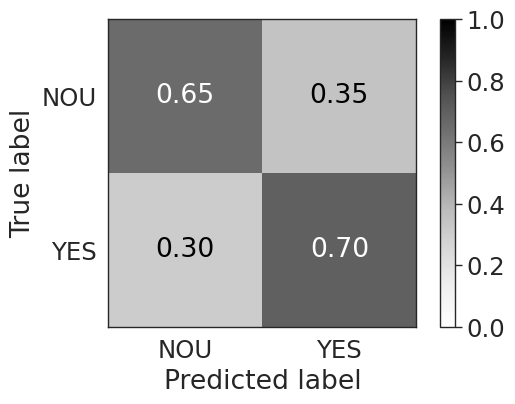

In [18]:
#| label: confusion1
# this function make pretty confusion matrices
confusion_matrix_mau(y_true=y_mau_true, y_pred=y_mau_predicted)

In [20]:

loaded_model_exposure = joblib.load('./results/models/trained_model_mau_mau.sav')

Accuracy on test set using the head: 0.65


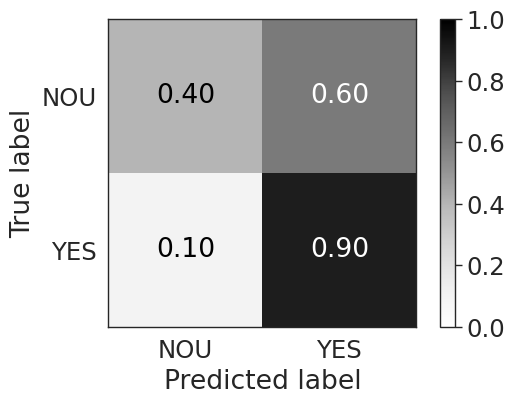

In [30]:
#| label: finaltest
y_hd_pred = loaded_model_exposure.predict(X_test)
acc = accuracy_score(y_true=y_test_species, y_pred=y_hd_pred)
print(f"Accuracy on test set using the head: {acc}")

confusion_matrix_mau(y_true=y_test_species, y_pred=y_hd_pred)

<Axes: xlabel='Accuracy_species', ylabel='Count'>

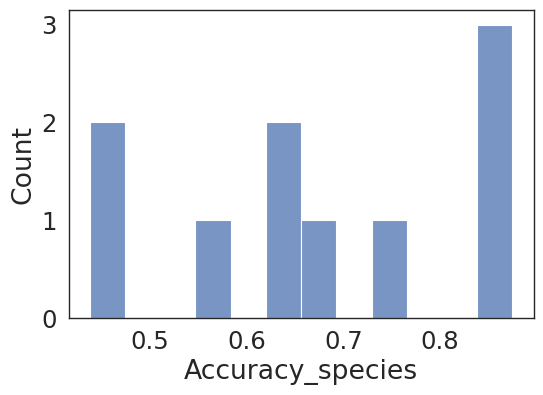

In [23]:
#|label: hist
sns.histplot(data=main_results, x='Accuracy_species',bins=12)